In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt


def print_score(y_pred, y_real, y_score, label_encoder, model_name):
    data = []
    
    data.append(["Accuracy", accuracy_score(y_real, y_pred)])
    data.append(["Precision (macro)", precision_score(y_real, y_pred, average='macro')])
    data.append(["Recall (macro)", recall_score(y_real, y_pred, average='macro')])
    data.append(["F1-score (macro)", f1_score(y_real, y_pred, average='macro')])
    data.append(["AUC-ROC (macro)", roc_auc_score(y_real, y_score, multi_class='ovr', average='macro')])
    
    for i in range(len(label_encoder.classes_)):
        class_name = label_encoder.inverse_transform([i])[0]
        data.append([f"Precision ({class_name})", precision_score(y_real, y_pred, labels=[i], average='weighted')])
        data.append([f"Recall ({class_name})", recall_score(y_real, y_pred, labels=[i], average='weighted')])
        data.append([f"F1-score ({class_name})", f1_score(y_real, y_pred, labels=[i], average='weighted')])
    
    score_df = pd.DataFrame(data, columns=["Metric", "Value"])
    display(score_df)

    # Save the score DataFrame to a CSV file
    score_df.to_csv(f"{model_name}_metrics.csv", index=False)


def plot_roc_curve(y_true, y_score, label_encoder, model_name):
    n_classes = len(label_encoder.classes_)

    if n_classes == 2:
        fpr, tpr, _ = roc_curve(y_true, y_score[:, 1])
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(10, 6)) 
        lw = 2
        plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) curve')
        plt.legend(loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        plt.show()
    else:
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true, y_score[:, i], pos_label=i)
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(10, 6))
        for i in range(n_classes):
            class_name = label_encoder.inverse_transform([i])[0]
            plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(class_name, roc_auc[i]))

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) curve for multi-class')
        plt.legend(loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        plt.show()
        fig = plt.gcf()  # Get the current figure
        # Save the figure to an image file
        fig.savefig(f"{model_name}_roc_curve.png", bbox_inches='tight')


from sklearn.metrics import PrecisionRecallDisplay

def plot_precision_recall_curve(y_true, y_score, label_encoder, model_name):
    n_classes = len(label_encoder.classes_)

    if n_classes == 2:
        precision, recall, _ = precision_recall_curve(y_true, y_score[:, 1])
        average_precision = average_precision_score(y_true, y_score[:, 1])

        plt.figure(figsize=(10, 6))  # Change the figure size here
        plt.step(recall, precision, where='post')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
        plt.show()
    else:
        y_true_binarized = label_binarize(y_true, classes=list(range(n_classes)))
        precision = dict()
        recall = dict()
        average_precision = dict()

        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_true_binarized[:, i], y_score[:, i])
            average_precision[i] = average_precision_score(y_true_binarized[:, i], y_score[:, i], average=None)

        # Plot Precision-Recall curve for each class
        plt.figure(figsize=(10, 6))  # Change the figure size here
        for i in range(n_classes):
            disp = PrecisionRecallDisplay(precision=precision[i], recall=recall[i])
            class_name = label_encoder.inverse_transform([i])[0]
            disp.plot(ax=plt.gca(), label='Precision-recall curve of class {0} (AP = {1:0.2f})'.format(class_name, average_precision[i]))

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('Precision-Recall curve for multi-class')
        plt.legend(loc="best", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        plt.show()
        fig = plt.gcf()  # Get the current figure
        # Save the figure to an image file
        fig.savefig(f"{model_name}_roc_curve.png", bbox_inches='tight')

def plot_class_accuracy(y_true, y_pred, label_encoder):
    n_classes = len(label_encoder.classes_)
    class_counts = np.zeros(n_classes)
    class_corrects = np.zeros(n_classes)

    for t, p in zip(y_true, y_pred):
        class_counts[t] += 1
        if t == p:
            class_corrects[t] += 1

    class_accuracies = class_corrects / class_counts
    class_names = label_encoder.inverse_transform(range(n_classes))

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, class_accuracies)
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Class')
    plt.xticks(rotation=45)
    plt.ylim([0.0, 1.05])
    plt.show()
    fig = plt.gcf()  # Get the current figure
    # Save the figure to an image file
    fig.savefig(f"{model_name}_class_accuracy.png", bbox_inches='tight')


# Load the dataset
file_path = '/content/drive/MyDrive/UNSW_NB15_training-set.csv'
df = pd.read_csv(file_path)


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

model_name = 'CNN'

# Convert categorical variables to dummy variables
cat_columns = ['proto', 'service', 'state']
df = pd.get_dummies(df, columns=cat_columns)

# Split the dataset into features and target
X = df.drop(['attack_cat', 'label'], axis=1)
y = df['attack_cat']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# One-hot encode the target variable for use with a CNN
y_onehot = to_categorical(y_encoded)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the input data into 3D format for use with Conv1D (samples, timesteps, features)
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Define the CNN architecture
model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, batch_size=64, epochs=100, validation_split=0.2)




Epoch 1/100
721/721 [==============================] - 24s 32ms/step - loss: 0.6368 - accuracy: 0.7952 - val_loss: 0.4425 - val_accuracy: 0.8467
Epoch 2/100
721/721 [==============================] - 20s 28ms/step - loss: 0.4284 - accuracy: 0.8511 - val_loss: 0.3971 - val_accuracy: 0.8522
Epoch 3/100
721/721 [==============================] - 23s 32ms/step - loss: 0.3908 - accuracy: 0.8603 - val_loss: 0.3738 - val_accuracy: 0.8580
Epoch 4/100
721/721 [==============================] - 20s 28ms/step - loss: 0.3737 - accuracy: 0.8651 - val_loss: 0.3539 - val_accuracy: 0.8618
Epoch 5/100
721/721 [==============================] - 22s 31ms/step - loss: 0.3573 - accuracy: 0.8699 - val_loss: 0.3516 - val_accuracy: 0.8627
Epoch 6/100
721/721 [==============================] - 20s 28ms/step - loss: 0.3458 - accuracy: 0.8723 - val_loss: 0.3383 - val_accuracy: 0.8656
Epoch 7/100
721/721 [==============================] - 21s 30ms/step - loss: 0.3366 - accuracy: 0.8746 - val_loss: 0.3378 - val_ac

In [ ]:
# Evaluate the model
score = model.evaluate(X_test_scaled, y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

772/772 [==============================] - 10s 13ms/step - loss: 0.3196 - accuracy: 0.8799
Test loss: 0.3195796310901642
Test accuracy: 0.8798785209655762


In [ ]:
# Make predictions
y_pred = np.argmax(model.predict(X_test_scaled), axis=-1)

# Calculate prediction probabilities
y_score = model.predict(X_test_scaled)

# Convert one-hot encoded y_test to class labels
y_test_labels = np.argmax(y_test, axis=-1)

# Print scores
print_score(y_pred, y_test_labels, y_score, label_encoder, model_name)

772/772 [==============================] - 5s 6ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Metric,Value
0,Accuracy,0.879879
1,Precision (macro),0.476046
2,Recall (macro),0.473199
3,F1-score (macro),0.464940
4,AUC-ROC (macro),0.975833
5,Precision (Analysis),0.000000
6,Recall (Analysis),0.000000
7,F1-score (Analysis),0.000000
8,Precision (Backdoor),0.000000
9,Recall (Backdoor),0.000000


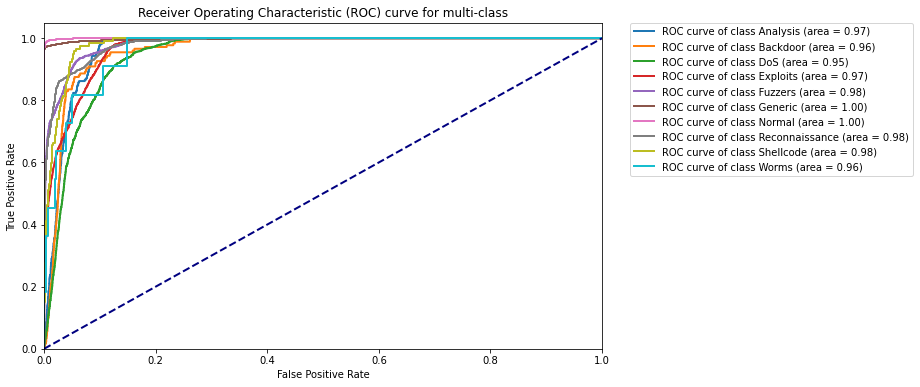

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot ROC curve
plot_roc_curve(y_test_labels, y_score, label_encoder, model_name)


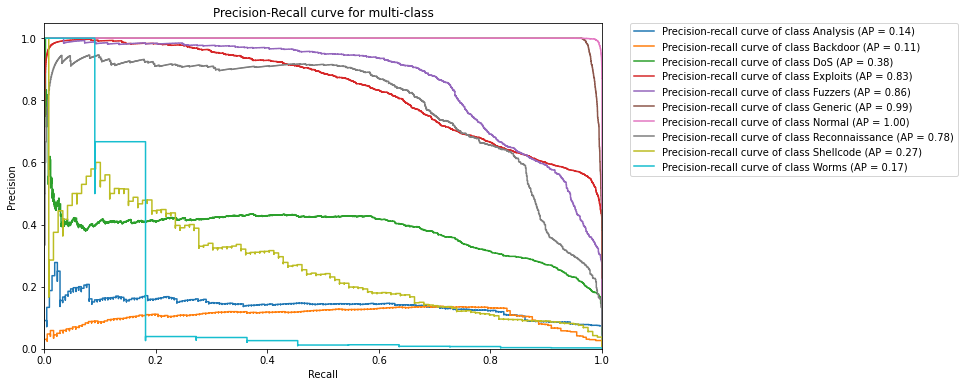

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot Precision-Recall curve
plot_precision_recall_curve(y_test, y_score, label_encoder, model_name)

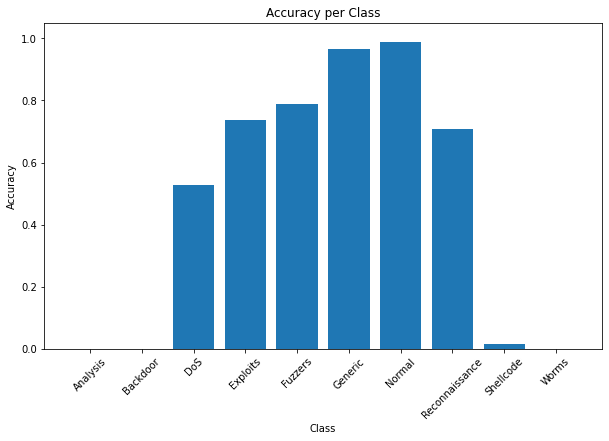

<Figure size 432x288 with 0 Axes>

In [ ]:

plot_class_accuracy(y_test_labels, y_pred, label_encoder)


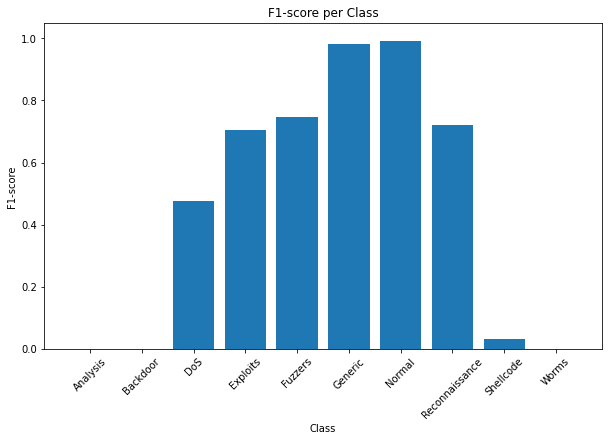

In [ ]:
from sklearn.metrics import f1_score

def plot_class_f1_score(y_true, y_pred, label_encoder):
    n_classes = len(label_encoder.classes_)
    f1_scores = []

    for i in range(n_classes):
        class_f1_score = f1_score(y_true, y_pred, labels=[i], average='weighted')
        f1_scores.append(class_f1_score)

    class_names = label_encoder.inverse_transform(range(n_classes))

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, f1_scores)
    plt.xlabel('Class')
    plt.ylabel('F1-score')
    plt.title('F1-score per Class')
    plt.xticks(rotation=45)
    plt.ylim([0.0, 1.05])
    fig = plt.gcf()  # Get the current figure
    plt.show()
    
    # Save the figure to an image file
    fig.savefig(f"{model_name}_class_f1_score.png", bbox_inches='tight')

plot_class_f1_score(y_test_labels, y_pred, label_encoder)


In [ ]:
import pandas as pd

# Load the CSV file
metrics_file = "CNN_metrics.csv"
metrics_df = pd.read_csv(metrics_file)

# Print the contents of the file
print(metrics_df)


                        Metric     Value
0                     Accuracy  0.879879
1            Precision (macro)  0.476046
2               Recall (macro)  0.473199
3             F1-score (macro)  0.464940
4              AUC-ROC (macro)  0.975833
5         Precision (Analysis)  0.000000
6            Recall (Analysis)  0.000000
7          F1-score (Analysis)  0.000000
8         Precision (Backdoor)  0.000000
9            Recall (Backdoor)  0.000000
10         F1-score (Backdoor)  0.000000
11             Precision (DoS)  0.432320
12                Recall (DoS)  0.528270
13              F1-score (DoS)  0.475503
14        Precision (Exploits)  0.674508
15           Recall (Exploits)  0.735680
16         F1-score (Exploits)  0.703767
17         Precision (Fuzzers)  0.709355
18            Recall (Fuzzers)  0.787340
19          F1-score (Fuzzers)  0.746316
20         Precision (Generic)  0.995431
21            Recall (Generic)  0.966637
22          F1-score (Generic)  0.980823
23          Prec